#### Extraindo o arquivo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile

# data_path = '/content/archive (3).zip'
data_path = '/content/drive/MyDrive/CIS/Dog_breed_classification/data.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()

#### Funções de pré-processamento e data augmentation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pathlib as pl
import cv2
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

Organizando as imagens em treino e teste (conforme a raça especificada)


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Caminho para a pasta com as imagens originais
# base_path = "/content/images/Images"
base_path = "/content/data"
output_path = "stanford-dogs-dataset-split/"
train_folder = os.path.join(output_path, "train")
test_folder = os.path.join(output_path, "test")

# Criando as pastas de saída
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Iterar sobre os subdiretórios de raças
for breed in os.listdir(base_path):
    breed_path = os.path.join(base_path, breed)
    if os.path.isdir(breed_path):  # Verifica se é uma pasta
        images = [img for img in os.listdir(breed_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Divide as imagens em treino e teste (80%-20%)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Criando as pastas específicas para cada raça
        train_breed_folder = os.path.join(train_folder, breed)
        test_breed_folder = os.path.join(test_folder, breed)
        os.makedirs(train_breed_folder, exist_ok=True)
        os.makedirs(test_breed_folder, exist_ok=True)

        # Movendo os arquivos para treino
        for img in train_images:
            shutil.copy(os.path.join(breed_path, img), os.path.join(train_breed_folder, img))

        # Movendo os arquivos para teste
        for img in test_images:
            shutil.copy(os.path.join(breed_path, img), os.path.join(test_breed_folder, img))

In [ ]:
train_dir = os.path.join(output_path, 'train')
test_dir = os.path.join(output_path, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# lendo o dataset de treino e teste
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      shuffle=True,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMG_SIZE,
                                                      labels="inferred")

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      shuffle=True,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMG_SIZE,
                                                      labels="inferred")

Found 16418 files belonging to 120 classes.
Found 4162 files belonging to 120 classes.


Definindo as funções de pré-processamento

In [ ]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights='imagenet')

from keras.preprocessing import image
# barra de progresso
from tqdm import tqdm

# transforma uma imagem em um tensor
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

# transforma imagens de uma lista em uma lista de tensores
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from keras.applications.resnet50 import preprocess_input, decode_predictions


def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

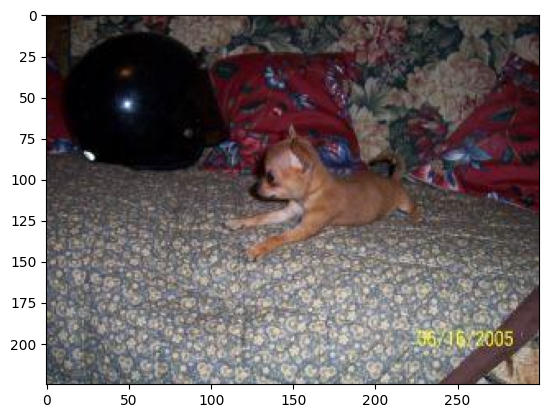

In [ ]:
import matplotlib.pyplot as plt


img_path = "/content/stanford-dogs-dataset-split/train/n02085620-Chihuahua/n02085620_6399.jpg"

img = plt.imread(img_path)
plt.imshow(img)
plt.show()

100%|██████████| 21.5M/21.5M [00:00<00:00, 133MB/s]



image 1/1 /content/stanford-dogs-dataset-split/train/n02085620-Chihuahua/n02085620_6399.jpg: 480x640 1 person, 1 dog, 907.6ms
Speed: 16.9ms preprocess, 907.6ms inference, 38.2ms postprocess per image at shape (1, 3, 480, 640)


<Figure size 1200x800 with 0 Axes>

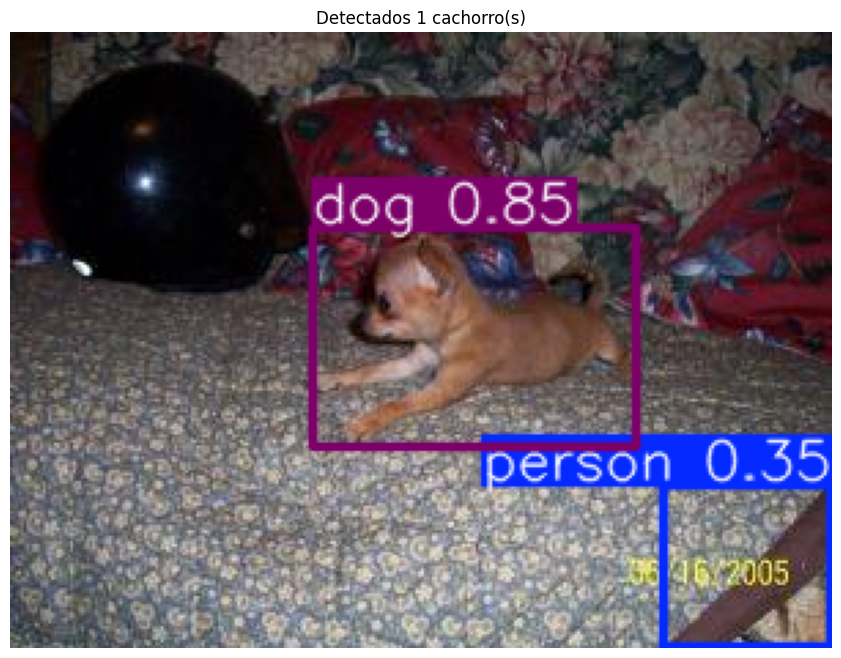

[{'bbox': [110.102875, 71.11485, 228.0954, 151.01263],
  'confidence': array(    0.84993, dtype=float32)}]

In [ ]:
model = YOLO('yolov8s.pt')  # usando o modelo nano do YOLOv8 para começar

def detect_dogs_yolo(img_path):
    # Fazer a predição
    results = model(img_path)

    # Filtrar apenas detecções de cachorros (classe 16 no COCO dataset)
    dogs = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Verificar se a classe é cachorro (16 no COCO)
            if int(box.cls) == 16:
                # Extrair coordenadas e confiança
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                confidence = box.conf[0].cpu().numpy()
                dogs.append({
                    'bbox': [x1, y1, x2, y2],
                    'confidence': confidence
                })

    return results, dogs

def visualize_detection(img_path):
    # Carregar a imagem
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Fazer a detecção
    results, dogs = detect_dogs_yolo(img_path)

    # Plotar a imagem com as detecções
    plt.figure(figsize=(12, 8))

    # Plotar as detecções originais do YOLO
    for result in results:
        boxes = result.plot()  # Plotar todas as detecções
        boxes = cv2.cvtColor(boxes, cv2.COLOR_BGR2RGB)
        plt.imshow(boxes)

    plt.title(f'Detectados {len(dogs)} cachorro(s)')
    plt.axis('off')
    plt.show()

    return dogs

plt.figure(figsize=(12, 8))
img_path = "/content/stanford-dogs-dataset-split/train/n02085620-Chihuahua/n02085620_6399.jpg"
visualize_detection(img_path)


image 1/1 /content/stanford-dogs-dataset-split/train/n02085620-Chihuahua/n02085620_6399.jpg: 480x640 1 person, 1 dog, 592.8ms
Speed: 4.2ms preprocess, 592.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


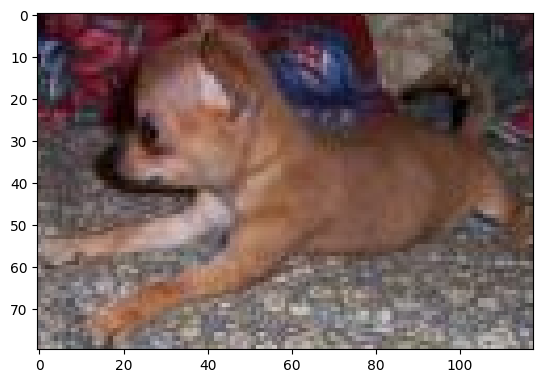

In [ ]:
def crop_dog_in_image(img_path):
  _, dogs = detect_dogs_yolo(img_path)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cropped_images = []
  for dog in dogs:
    x1, y1, x2, y2 = dog['bbox']
    cropped_image = img[int(y1):int(y2), int(x1):int(x2)]
    cropped_images.append(cropped_image)
  return cropped_images

plt.imshow(crop_dog_in_image(img_path)[0])
plt.show()

## Detectando a Raça

In [ ]:
# carregando os pesos do modelo
weights_path = '/content/drive/MyDrive/CIS/Dog_breed_classification/transfer_learning_model.keras'

# define o modelo
def create_model():
  base_model = keras.applications.ResNet50(input_shape=(IMG_SIZE + (3,)),
                                               include_top=False,
                                               weights='imagenet')
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(120, activation="softmax")(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.01

  sgd = keras.optimizers.SGD(learning_rate=base_learning_rate, clipnorm=1, decay=1e-6,
            momentum = 0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
model = create_model()

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │         245,880 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,833,592 (90.92 MB)

 Trainable params: 245,880 (960.47 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.load_weights(weights_path)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 4 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### testando a predição do modelo

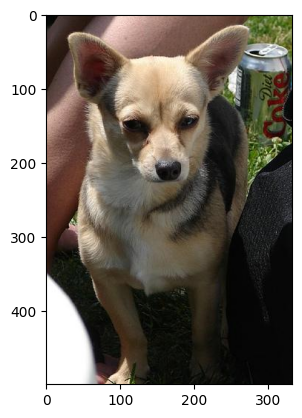

In [ ]:
# testing the model with an image
img_inf_path = "/content/stanford-dogs-dataset-split/train/n02085620-Chihuahua/n02085620_10074.jpg"
img = plt.imread(img_inf_path)
plt.imshow(img)
plt.show()

In [ ]:
breeds = [breed[10:] for breed in train_ds.class_names]

breeds

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih-Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black-and-tan_coonhound',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Italian_greyhound',
 'whippet',
 'Ibizan_hound',
 'Norwegian_elkhound',
 'otterhound',
 'Saluki',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire-haired_fox_terrier',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft-coated_wheaten_terrier',
 'West_Highland_wh

In [ ]:
img = image.load_img(img_inf_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32')
img_array /= 255.0

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(f"Predicted class: {breeds[predicted_class-1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Chihuahua
